In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize


In [3]:
df = pd.read_csv('2024_homework/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


## 1 Clean and prepare the data

Churn prediction is about identifying customers who are likely to cancel their contracts soon. If the company can do that, it can offer discounts on these services in an effort to keep the users. Here we use the dataset of churn prediction for a telecom company.

- A value of 0 indicates that the customer did not churn (they stayed with the service).
- A value of 1 indicates that the customer did churn (they left the service).

When import a CSV file, Pandas tries to guess the right type for each column. But sometimes, it doesn't get it right. So, it's a good idea to double-check the types using ``df.dtypes`` and put the data correctly:
-We observe that the `TotalCharges` column poses an issue. Rather than being classified as a numeric type, such as float or integer, pandas incorrectly infers it as an object type.
-We see that some columns has 'yes' or 'no' string, that we can convert to boolean. First consider the target variable churn


In [4]:
# put all header column lower case, replace the space
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')


# propblem in totalcharges :  some value are not numeric so force numeric
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df['totalcharges'] = df['totalcharges'].fillna(0)
df.churn = (df.churn == 'yes').astype(int)
df

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-resvb,male,0,yes,yes,24,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,yes,mailed_check,84.80,1990.50,0
7039,2234-xaduh,female,0,yes,yes,72,yes,yes,fiber_optic,no,...,yes,no,yes,yes,one_year,yes,credit_card_(automatic),103.20,7362.90,0
7040,4801-jzazl,female,0,yes,yes,11,no,no_phone_service,dsl,yes,...,no,no,no,no,month-to-month,yes,electronic_check,29.60,346.45,0
7041,8361-ltmkd,male,1,yes,no,4,yes,yes,fiber_optic,no,...,no,no,no,no,month-to-month,yes,mailed_check,74.40,306.60,1


In [5]:
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


We see that the dataset has a few columns:
- CustomerID: the ID of the customer
- Gender: male/female
- SeniorCitizen: whether the customer is a senior citizen (0/1)
- Partner: whether they live with a partner (yes/no)
- Dependents: whether they have dependents (yes/no)
- Tenure: number of months since the start of the contract
- PhoneService: whether they have phone service (yes/no)
- MultipleLines: whether they have multiple phone lines (yes/no/no phone service)
- InternetService: the type of internet service (no/fiber/optic)
- OnlineSecurity: if online security is enabled (yes/no/no internet)
- OnlineBackup: if online backup service is enabled (yes/no/no internet)
- DeviceProtection: if the device protection service is enabled (yes/no/no internet)
- TechSupport: if the customer has tech support (yes/no/no internet)
- StreamingTV: if the TV streaming service is enabled (yes/no/no internet)
- StreamingMovies: if the movie streaming service is enabled (yes/no/no internet)
- Contract: the type of contract (monthly/yearly/two years)
- PaperlessBilling: if the billing is paperless (yes/no)
- PaymentMethod: payment method (electronic check, mailed check, bank transfer,
credit card)
- MonthlyCharges: the amount charged monthly (numeric)
- TotalCharges: the total amount charged (numeric)
- Churn: if the client has canceled the contract (yes/no)

We now split the code into train, validation and test
60%,20%,20%
using the function we need to split twice, and to obtain 20% of the total from 80% we need to take 25% 20/80

In [6]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

len(df_train),len(df_val),len(df_test)

(4225, 1409, 1409)

# Exploratory Data Analysis (EDA)
We have already found a problem with the TotalCharges column and replaced the missing values with zeros. Now let’s see if we need to perform any additional null handling:


In [7]:
df_train_full.isnull().sum()[df_train_full.isnull().sum() != 0]

Series([], dtype: int64)

In [8]:
df_train_full.churn.value_counts()

churn
0    4113
1    1521
Name: count, dtype: int64

Let’s check the proportion of churned users among all customers. This is the **Global Churn Rate** that refers to the overall churn rate for the entire customer base of the dataset.

In [9]:
churn_stats = df_train_full['churn'].value_counts().to_frame(name='count')
churn_stats['global_mean'] = round(churn_stats['count'] / churn_stats['count'].sum(), 3)
#churn_stats['global_mean'] = round(df_train_full['churn'].value_counts(normalize=True), 3)

display(churn_stats)


,count,global_mean
churn,,
0,4113,0.73
1,1521,0.27


Let's separate the dataset in categorical and numerical variables:

In [10]:
# All categorical columns except 'customerid'
categorical_mask = df_train.dtypes == 'object'
categorical = list(df_train.dtypes[categorical_mask].index)
categorical.remove('customerid')

# Manually add 'seniorcitizen' because it's an int boolean (0 or 1)
categorical.append('seniorcitizen')
print('categorical', categorical)

# All numerical columns except 'seniorcitizen' because it's an int boolean
numerical_mask = df_train.dtypes != 'object'
numerical = list(df_train.dtypes[numerical_mask].index)
numerical.remove('seniorcitizen')
print('numerical = ', numerical)

#Count number of distinct elements in specified axis,

df_train_full[categorical].nunique()

categorical ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'seniorcitizen']
numerical =  ['tenure', 'monthlycharges', 'totalcharges']


gender              2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
seniorcitizen       2
dtype: int64

## Feature importance Churn rate and risk ratio
**Global Churn Rate (mean)**

In the context of the churn dataset, taking the mean of the churn feature effectively calculates the proportion of customers who have churned. This is because the churn feature is binary, meaning that taking its mean provides the proportion (or fraction) of the total customers who have churned. Here, the term 'global' indicates that the rate is calculated over all customers.



**Group Churn Rate (Mean Churn within a Specific Group)**

The Group Churn Rate in the churn dataset represents the average churn specifically for a subset of customers, often defined by certain shared characteristics or attributes. Since the churn feature is binary, this calculated average signifies the proportion of customers in that subset who have churned.

Comparing the Group Churn Rate with the Global Churn Rate offers insights into how a particular subgroup of customers behaves in contrast to the overall customer base. If the Group Churn Rate closely aligns with the Global Churn Rate, it suggests that this group's churn behavior mirrors the overall trend. On the other hand, a significant deviation between the two rates indicates that the group's churn behavior is notably different from that of the overall customers.



Now, let's start our analysis with the gender variable:

In [11]:


female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()
print('gender == female:', round(female_mean, 3))

male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()
print('gender == male:  ', round(male_mean, 3))



gender == female: 0.277
gender == male:   0.263


# Churn Mean over all partners and not partners costumers
partner_mean = df_train_full.groupby('partner')['churn'].mean()
display(partner_mean)The difference between the group rates for both males and females is quite small, which indicates that knowing the gender of the customer
doesn’t help us identify whether they will churn.

Now let’s take a look at another variable: partner:

In [12]:
# Churn Mean over all partners and not partners costumers
partner_mean = df_train_full.groupby('partner')['churn'].mean()
partner_mean

partner
no     0.329809
yes    0.205033
Name: churn, dtype: float64

The churn rate for people with a partner is significantly less than the rate for the ones without a partner — 20.5% versus 33%. It means that clients with no partner are more likely to churn than the ones with a partner

**Risk Ratio (or Relative Risk)**

As discussed, comparing the Group Churn Rate with the Global Churn Rate provides insights into how a particular subgroup of customers behaves relative to the overall customer base.

This understanding naturally leads to the question: How can we best quantify this deviation or alignment between the Group Churn Rate and the Global Churn Rate? The answer lies in calculating their ratio, termed the Risk Ratio.

$$\text{Risk Ratio} =\frac{\text{Group Churn Rate}}{\text{Global Churn Rate}} $$

The risk ratio can range from zero to infinity. This metric provides a means to measure the degree to which a specific group of customers aligns or diverges from the overall customer tendency.

We can interpret the risk ratio values as follows:

- $\text{Risk Ratio} > 1$: The group has a higher churn rate compared to the overall customers. This implies that members of this group are more likely to churn.

- $\text{Risk Ratio} = 1$: The group's churn rate is equivalent to that of the overall customers, meaning the group's likelihood to churn mirrors that of the overall customers.

- $\text{Risk Ratio} < 1$: The group has a lower churn rate compared to the overall customers. Customers within this group are less likely to churn.




In [13]:
global_mean = df_train_full.churn.mean()
for col in categorical:
    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean 
    display(df_group)

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,risk
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,risk
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,risk
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,risk
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,risk
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,risk
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,risk
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,risk
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,risk
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,risk
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,risk
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,risk
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


,mean,diff,risk
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


## ML Zoomcamp 3.6 - Feature Importance: Mutual Information
Entropy and Conditional entropy, how does it relate to mutual information
## **Mutual information**

Mutual information was introduced to quantify how much information knowing one variable gives about another.

A straightforward way to think about this is to measure how much the entropy (uncertainty) of $\mathbf{X}_l$  reduces when $\mathbf{Y}$ is known. This is given by the difference between the entropy of $\mathbf{X}_l$ and the conditional entropy of $\mathbf{X}_l$ given $\mathbf{Y}$:

$$MI(\mathbf{X}_l;\mathbf{Y}) = H(\mathbf{X}_l) − H(\mathbf{X}_l|\mathbf{Y})$$

Thus mutual information quantifies the amount of information gained about $\mathbf{X}_l$ after learning about $\mathbf{Y}$, and the amount of information gained about $\mathbf{Y}$ after learning about $\mathbf{X}_l$. This is because mutual information is symmetric, i.e., $MI(\mathbf{X}_l;\mathbf{Y}) = MI(\mathbf{Y};\mathbf{X}_l)$.

Here's how to interpret mutual information:

- **If $MI(\mathbf{X}_l;\mathbf{Y})$ is high:** A high value of mutual information means a value closer to  $H(\mathbf{X}_l)$ or $H(\mathbf{Y})$.  knowing $\mathbf{Y}$ reduces our uncertainty about $\mathbf{X}_l$, and knowing $\mathbf{X}_l$ reduces our uncertainty about $\mathbf{Y}$. This is the case where $\mathbf{X}_l$ and $\mathbf{Y}$ have some dependency.

- **If $MI(\mathbf{X}_l;\mathbf{Y})$ is zero:**  knowing $\mathbf{Y}$ does nothing to decrease our uncertainty about $\mathbf{X}_l$, and knowing $\mathbf{X}_l$ does nothing to decrease our uncertainty about $\mathbf{Y}$. This is the case when $\mathbf{X}_l$ and $\mathbf{Y}$ are independent.

In [14]:
from sklearn.metrics import mutual_info_score


def calculate_mi(series):
    return mutual_info_score(series, df_train_full.churn)

df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')


display(df_mi.head())
display(df_mi.tail())



,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923


,MI
partner,0.009968
seniorcitizen,0.009410
multiplelines,0.000857
phoneservice,0.000229
gender,0.000117


#  Feature Importance: Correlation

**Pearson's correlation coefficient**

While mutual information can effectively quantify the degree of dependency between two categorical variables, it doesn't function well when one of the variables is numerical. Hence, it isn't appropriate for the three numerical variables in our dataset.

Instead, Pearson's correlation coefficient can be used as a measure of the linear correlation or dependence between two variables, X and Y. The coefficient provides a value between $[1, −1]$, where:

- 1 is a total positive linear correlation,
- 0 is no linear correlation
- −1 is a total negative linear correlation.

the correlation for a pair of random variables $(X, Y)$ is given by:

$$
\rho(X,Y) = \frac{\text{cov}(X,Y)}{\sigma_X \sigma_Y}
$$

In this equation, $\text{cov}(X,Y)$ represents the covariance between X and Y, while $\sigma_X$ and $\sigma_Y$ are the standard deviations of X and Y, respectively. The covariance, a measure of how much two random variables change together, is computed as follows:

$\text{cov}(X,Y) = E[(X - E[X])(Y - E[Y])]$

Here, $E[X]$ and $E[Y]$ are the expected values (or means) of X and Y, respectively. This formula essentially captures the joint variability of X and Y.

The standard deviations, which measure the dispersion or spread of the data points from the mean, are computed as follows:

$$\sigma_X = \sqrt{E[X^2] - E[X]^2}$$
$$\sigma_Y = \sqrt{E[Y^2] - E[Y]^2}$$

Pearson's correlation coefficient can be a valuable tool to understand and visualize the linear relationships between features. This can inform feature selection, as highly correlated features often carry redundant information

Let's translate this to python code:

In [15]:
df_train_full[numerical].corrwith(df_train_full.churn).to_frame('correlation')

,correlation
tenure,-0.351885
monthlycharges,0.196805
totalcharges,-0.196353


In [16]:
def pearson_corr(x, y):
    # Compute the means of X and Y
    mean_x = x.agg(np.mean)
    mean_y = y.agg(np.mean)

    mean_x_values = mean_x.values
    x_labels = mean_x.index
    x_values = x.values

    mean_y = y.agg(np.mean)
    y_values = y.values.reshape(-1,1)

    # Compute the covariance
    cov_XY = np.mean((x_values - mean_x_values) * (y_values - mean_y), axis = 0)

    # Compute the standard deviations
    std_X = np.sqrt(np.mean((x_values - mean_x_values)**2, axis = 0))
    std_Y = np.sqrt(np.mean((y_values - mean_y)**2, axis = 0))

    # Compute the correlation
    corr_XY = cov_XY / (std_X * std_Y)

    # Create the DataFrame
    corr_XY = pd.DataFrame(corr_XY, index=x_labels, columns=['pearson_correlation'])
    return corr_XY
def pearson_corr_matrix(df):

    # Select numeric features
    is_numeric = df.dtypes != 'object'
    numerical = list(df.dtypes[is_numeric].index)

    n = len(numerical)
    corr_matrix = np.zeros((n, n))

    for i, feature_i in zip(range(n), numerical ):
        for j, feature_j in zip(range(n), numerical ):
            # Select numerical features x and y
            x = df[feature_i]
            y = df[feature_j]

            # compute the means
            mean_x = np.mean(x)
            mean_y = np.mean(y)

            # Compute the covariance
            cov_XY = np.mean((x - mean_x) * (y - mean_y))
            # Compute the standard deviations
            std_X = np.sqrt(np.mean((x - mean_x)**2))
            std_Y = np.sqrt(np.mean((y - mean_y)**2))

            # Compute the correlation of features x and y
            corr_matrix[i, j] = cov_XY / (std_X * std_Y)

    return pd.DataFrame(corr_matrix, index=numerical, columns=numerical)

In [17]:
correlation_matrix = pearson_corr_matrix(df_train_full)
correlation_matrix

,seniorcitizen,tenure,monthlycharges,totalcharges,churn
seniorcitizen,1.000000,0.023443,0.225234,0.110459,0.141966
tenure,0.023443,1.000000,0.251072,0.828268,-0.351885
monthlycharges,0.225234,0.251072,1.000000,0.650913,0.196805
totalcharges,0.110459,0.828268,0.650913,1.000000,-0.196353
churn,0.141966,-0.351885,0.196805,-0.196353,1.000000


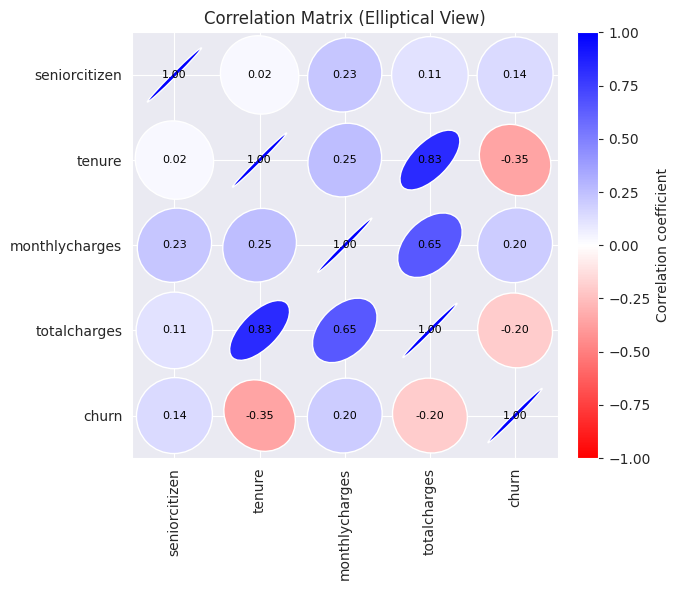

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

def plot_corr_ellipses(data, figsize=None, annotate=True, **kwargs):
    '''Improved correlation ellipse plot: https://stackoverflow.com/a/34558488'''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')

    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'aspect': 'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # Ellipse positions
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # Ellipse dimensions and angles
    w = np.ones_like(M).ravel() * 0.9  # Constant width
    # h = np.sqrt(np.abs(M).ravel()) * 0.9 + 0.05
    h = np.sqrt(1 - np.abs(M).ravel()) * 0.9 + 0.05  # usual: strong corr = line
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(
        widths=w,
        heights=h,
        angles=a,
        units='x',
        offsets=xy,
        transOffset=ax.transData,
        array=M.ravel(),
        norm=Normalize(vmin=-1, vmax=1),
        **kwargs
    )
    ax.add_collection(ec)

    # Annotations
    if annotate:
        for (i, j), val in np.ndenumerate(M):
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=8, color='black')

    # Tick labels from DataFrame
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec, ax
m, ax = plot_corr_ellipses(correlation_matrix, figsize=(10, 6), cmap='bwr_r')
cb = plt.colorbar(m, ax=ax, pad=0.02)
cb.set_label('Correlation coefficient', fontsize=10)
plt.title("Correlation Matrix (Elliptical View)")
plt.tight_layout()
plt.show()


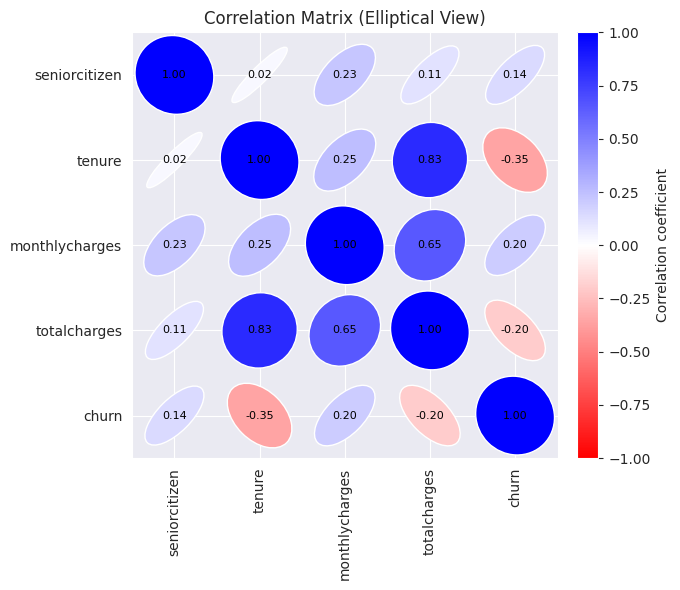

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

def plot_corr_ellipses(data, figsize=None, annotate=True, **kwargs):
    '''Improved correlation ellipse plot: https://stackoverflow.com/a/34558488'''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')

    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'aspect': 'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # Ellipse positions
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # Ellipse dimensions and angles
    w = np.ones_like(M).ravel() * 0.9  # Constant width
    h = np.sqrt(np.abs(M).ravel()) * 0.9 + 0.05
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(
        widths=w,
        heights=h,
        angles=a,
        units='x',
        offsets=xy,
        transOffset=ax.transData,
        array=M.ravel(),
        norm=Normalize(vmin=-1, vmax=1),
        **kwargs
    )
    ax.add_collection(ec)

    # Annotations
    if annotate:
        for (i, j), val in np.ndenumerate(M):
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=8, color='black')

    # Tick labels from DataFrame
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec, ax
m, ax = plot_corr_ellipses(correlation_matrix, figsize=(10, 6), cmap='bwr_r')
cb = plt.colorbar(m, ax=ax, pad=0.02)
cb.set_label('Correlation coefficient', fontsize=10)
plt.title("Correlation Matrix (Elliptical View)")
plt.tight_layout()
plt.show()


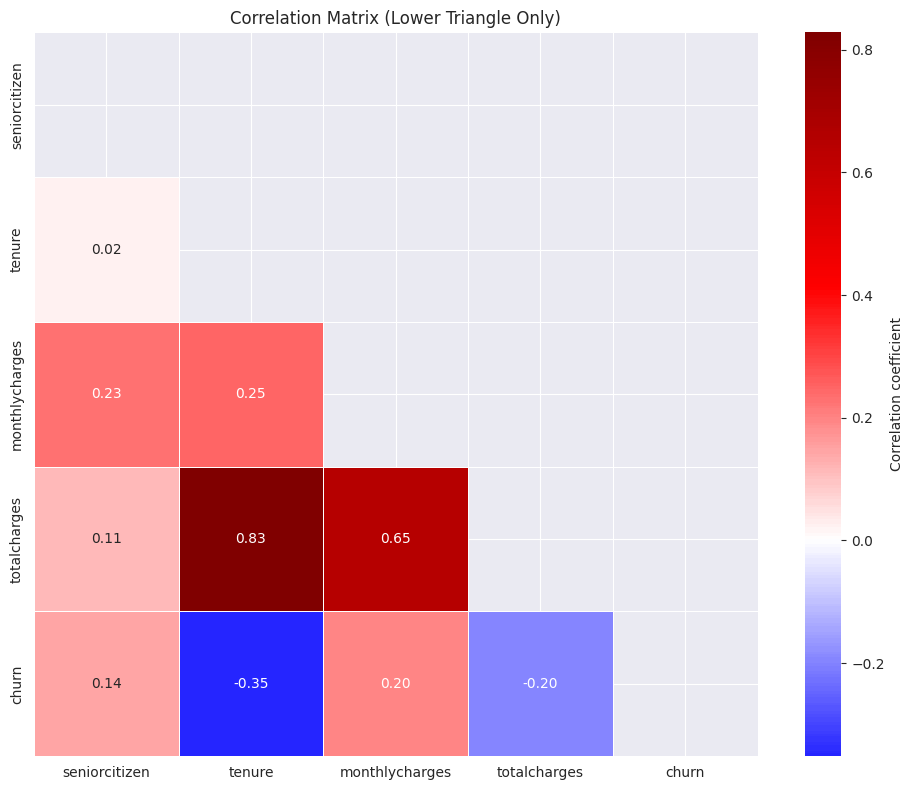

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_correlation_matrix_heatmap(corr_matrix, figsize=(10, 8), cmap='seismic', annot=True, mask_upper=True):
    """
    Plots a traditional heatmap-style correlation matrix using seaborn.
    Optionally masks the upper triangle.
    """
    mask = None
    if mask_upper:
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=annot,
        fmt=".2f",
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"label": "Correlation coefficient"}
    )
    plt.title("Correlation Matrix (Lower Triangle Only)" if mask_upper else "Correlation Matrix")
    plt.tight_layout()
    plt.show()

# Call the function
plot_correlation_matrix_heatmap(correlation_matrix, mask_upper=True, cmap='seismic')


bAs we can see:

- `tenure` has a high negative correlation (-0.35): as tenure grows, churn rate goes down.

- `monthlycharges` has positive correlation (0.19): the more customers pay, the more likely they are to churn

In [21]:
df_train_full.groupby(by='churn')[numerical].mean()

,tenure,monthlycharges,totalcharges
churn,,,
0,37.531972,61.176477,2548.021627
1,18.070348,74.521203,1545.689415



# 3.8 One-hot encoding
When dealing with a categorical variable like "contract" with multiple possible values (e.g., monthly, yearly, and two-year), we can use a technique called one-hot encoding to represent each value as a binary vector. In this case, if we have a customer with a yearly contract, the one-hot encoding representation would be (0, 1, 0).

This encoding scheme works by designating the "active" or "hot" value as 1, while the other values are considered "not active" or "cold" and assigned a value of 0. In our example, the yearly contract is the active value, so it receives a 1, while the monthly and two-year contracts are not active and receive 0.

In [22]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
val_dict = df_val[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_train.shape

(4225, 45)

## ENcoding
# **Logistic Regression**

Consider a hypothetical dataset with multiple features $\mathbf{X}_{1},\cdots, \mathbf{X}_{d}$ and a target variable $\mathbf{Y}$ as shown:

$$
\left( \begin{array}{c|cccc|c}
\text{Instance}    &\mathbf{X}_{0}&\mathbf{X}_{1}&\cdots & \mathbf{X}_{d}  & \mathbf{Y}\\
\hline
\mathbf{x}_{1} &1& x_{11}& \cdots&x_{1d}&y_1 \\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
\mathbf{x}_{n}&1&x_{n1}&\cdots&x_{nd}&y_n
\end{array} \right).$$

Here, each row vector is an instance $\mathbf{x}_i = (1, x_{i1}, \ldots, x_{id})$ of the dataset with $ d+1 $ values. The first column, $ \mathbf{X}_0 $, is the intercept term (or bias) and is set to $1$ for all instances. The dataset is separated in a feature matrix $\mathbf{X}$ and a binary target vector $\mathbf{Y}$:


$$\mathbf{X}=
\left( \begin{array}{cccc}
 1& x_{11}& \cdots&x_{1d} \\
\vdots&\vdots&\ddots&\vdots&\\
1&x_{n1}&\cdots&x_{nd}
\end{array} \right) ~~~ \text{and} ~~~

\mathbf{Y} = \left( \begin{array}{c}
y_1\\
\vdots\\
y_n
\end{array} \right)
$$

The target vector $\mathbf{Y}$ consists of binary values, either 0 or 1, hence forming the set $\mathcal{Y}=\{0,1\}$.

Since there are only two possible unique values for $Y$, the conditional probabilities can be defined as:

$$p(\mathbf{Y} = 1|\mathbf{X}= \mathbf{x}_i) = \pi( \mathbf{x}_i) ~~\text{and}~~~p(\mathbf{Y} = 0|\mathbf{X}= \mathbf{x}_i) = 1- \pi( \mathbf{x}_i)$$

This notation indicates that we're looking at the conditional probability of $ \mathbf{Y} $ being 1 given a specific instance $ \mathbf{x}_i $. Here, $ \pi( \mathbf{x}_i) $ represents an unknown function of the instances. Our primary objective in logistic regression is to estimate this function, $ \pi( \mathbf{x}_i) $, which essentially defines our logistic regression model.

A naive approach would be to directly use linear regression for the function $ \pi( \mathbf{x}_i) = \mathbf{x}_i\mathbf{w}$, where $\mathbf{w} = (w_0, \ldots, w_d)^T$ is the weights that will be learned by the model. This would  result in

$$p(\mathbf{Y} = 1|\mathbf{X}= \mathbf{x}_i) = \mathbf{x}_i\mathbf{w}.$$

However due to the fact that $\mathbf{x}_i\mathbf{w}$ can assume values in the range $(- \infty,+ \infty)$ is not possible to use as a probability model. We require that the output represents a probability values, and thus we need a model that results in an output that lies in the range $[0,1]$. For this task we rely in the sigmoid function, this function is also know as logistic function. The logistic function is defined as follows:

---

- **Sigmoid**
    $$\theta(z) = \frac{1}{1+e^{-z}} = \frac{e^{z}}{1+e^{z}}$$

    for any $z \in \mathbb{R}$ the output is $\theta(z) \in [0,1]$. An interesting property of the logistic function is that $1 - \theta(z) = \theta(-z)$:

$$1-\theta(z) = 1 - \frac{1}{1+ e^{-z}} = \frac{e^{-z}}{1+ e^{-z}} = \frac{1}{1+ e^{z}} =  \theta(-z)~~\square$$
---
We now can maps this linear combination $\mathbf{x}_i\mathbf{w}$ through the logistic (sigmoid) function to get a value that represents a probability between 0 and 1. We can address the probability as $p(\mathbf{Y} = 1|\mathbf{X}= \mathbf{x}_i) = \theta(\mathbf{x}_i\mathbf{w})$ and define the logistic regression model as follows:

$$
\begin{align*}
p(\mathbf{Y} = 1|\mathbf{X} = \mathbf{x}_i) &= \theta(\mathbf{x}_i\mathbf{w}) \\
&= \frac{e^{\mathbf{x}_i\mathbf{w}}}{1+ e^{\mathbf{x}_i\mathbf{w}}}~~~\text{and}\\
\\
p(\mathbf{Y} = 0|\mathbf{X} = \mathbf{x}_i) &= 1 - p(\mathbf{Y} = 1|\mathbf{X} = \mathbf{x}_i)\\
&= \frac{1}{1 + e^{\mathbf{x}_i\mathbf{w}}}\\
& = \theta(-\mathbf{x}_i\mathbf{w})
\end{align*}
$$

where in $p(\mathbf{Y} = 0|\mathbf{X} = \mathbf{x}_i)$ we use the property $1 - \theta(z) = \theta(-z)$. The model then can be formulated from the following probability:

$$p(\mathbf{Y}|\mathbf{X} = \mathbf{x}_i) = \theta(\mathbf{x}_i\mathbf{w})^{y}\theta(-\mathbf{x}_i\mathbf{w})^{1-y}$$

where $y \in \mathcal{Y} = \{0,1\}$, which can be considered a Bernoulli random variable that takes on either the values 0 or 1. We can observe that


$$ p(\mathbf{Y} = 1|\mathbf{X} = \mathbf{x}_i) = \theta(\mathbf{x}_i\mathbf{w}) ~~\text{and} ~~ p(\mathbf{Y} = 0|\mathbf{X} = \mathbf{x}_i) = \theta(-\mathbf{x}_i\mathbf{w})$$

**Maximum Likelihood Estimation**

In logistic regression, we use the maximum likelihood estimation (MLE) approach to find the optimal weight vector, $ \mathbf{w} = (w_0, \ldots, w_d)^T $. The likelihood function quantifies how well our model, parameterized by $ \mathbf{w} $, explains the observed data. Consider the joint probability of observing the entire target vector $ \mathbf{Y} $ given the feature matrix $ \mathbf{X} $ under a particular parametrization $ \mathbf{w} $:

$$ \mathcal{L}(\mathbf{w}) = p(\mathbf{Y}|\mathbf{X}; \mathbf{w} ) = P(y_1, \ldots, y_n|\mathbf{x}_1, \ldots, \mathbf{x}_n; \mathbf{w} ) $$

If we assume that the observed outcomes in vector $\mathbf{Y}$, given their corresponding features in matrix $\mathbf{X}$, are conditionally independent given the model parameters $\mathbf{w}$, then we can factorize the likelihood of the entire dataset as the product of the likelihoods of each individual observation:

$$ \mathcal{L}(\mathbf{w}) = \prod_{i=1}^{n} P(y_i|\mathbf{x}_i; \mathbf{w} )  $$

Each term $ P(y_i|\mathbf{x}_i; \mathbf{w} ) $ represents the probability that instance $ i $ belongs to its observed class given its features and the model parameters. Substituting the logistic model into the likelihood we get

$$\mathcal{L}(\mathbf{w}) =  \prod_{i = 1}^{n} \theta(\mathbf{x}_i\mathbf{w})^{y_i}\theta(-\mathbf{x}_i\mathbf{w})^{1-y_i}$$

Our aim is to find the value of $\mathbf{w}$ that maximizes this likelihood, an approach known as Maximum Likelihood Estimation (MLE). In practice, we often maximize the logarithm of the likelihood (log-likelihood) to convert the product into a sum:

$$
\begin{align*}
\log(\mathcal{L}(\mathbf{w})) & = \log \left(\prod_{i = 1}^{n} \theta(\mathbf{x}_i\mathbf{w})^{y_i}\theta(-\mathbf{x}_i\mathbf{w})^{1-y_i}\right) \\
& = \sum_{i = 1}^{n} y_i\log(\theta(\mathbf{x}_i\mathbf{w})) + (1-y_i)\log(\theta(-\mathbf{x}_i\mathbf{w}))
\end{align*}
$$

Substituting the logistic function into this equation further simplifies it:

$$\log(\mathcal{L}(\mathbf{w})) = \sum_{i = 1}^{n} y_i\log \left(\frac{e^{\mathbf{x}_i\mathbf{w}}}{1+ e^{\mathbf{x}_i\mathbf{w}}}\right) + (1-y_i)\log \left(\frac{1}{1 + e^{\mathbf{x}_i\mathbf{w}}}\right)$$

Typically in optimization, we don't maximize this log-likelihood directly. Instead, we minimize the negative of this quantity, which is called the log-loss or cross-entropy loss function. This function serves as a loss function during training:

$$\text{loss}(\mathbf{w}) = -\log(\mathcal{L}(\mathbf{w})) = -\sum_{i = 1}^{n} y_i\log \left(\frac{e^{\mathbf{x}_i\mathbf{w}}}{1+ e^{\mathbf{x}_i\mathbf{w}}}\right) - (1-y_i)\log \left(\frac{1}{1 + e^{\mathbf{x}_i\mathbf{w}}}\right)$$

This cross-entropy loss comes directly from the negative log-likelihood of the Bernoulli distribution, and this is why it's appropriate for binary classification problems like this one. It measures the dissimilarity between the ground-truth labels and the predicted probabilities. The better our predictions, the lower the cross-entropy loss.

To obtain the optimal weights vector $\mathbf{w}$, we would typically differentiate the log-likelihood function with respect to $\mathbf{w}$, equate the result to zero, and then solve for $\mathbf{w}$. However, unlike linear regression, the log-likelihood formulation lacks a closed form solution for the weight vector. Instead, we use methods like gradient ascent due to the concavity of the log-likelihood function, which ensures a unique global maximum. After calculating the optimal weights, we can use the model equation to make prediction.



In [23]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [24]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)
y_pred[:,1]

array([0.23200084, 0.2477357 , 0.27713303, ..., 0.00226805, 0.1225775 ,
       0.00144123], shape=(1409,))


The first column of the array contains the probability that the target is negative
(no churn), and the second column contains the probability that the target is positive
(churn).

To make the actual decision about whether to send a promotional letter to our customers,
using the probability alone is not enough. We need hard predictions — binary
values of True (churn, so send the mail) or False (not churn, so don’t send the mail). To get the binary predictions, we take the probabilities and cut them above a certain
threshold. If the probability for a customer is higher than this threshold, we predict
churn, otherwise, not churn. If we select 0.5 to be this threshold, making the
binary predictions is easy.

In [25]:
p = y_pred[:,1]
churn = p > 0.5
print('prediction of clients that churn:',churn)
print('clients that churn:',y_val)
# True if our prediction is correct and False if it’s not.
print('predictions', y_val == churn)
accuracy = (y_val == churn).mean()
print('accuracy', accuracy)



prediction of clients that churn: [False False False ... False False False]
clients that churn: [0 1 0 ... 0 0 0]
predictions [ True False  True ...  True  True  True]
accuracy 0.7991483321504613


# Model interpretation
For logistic regression the model learn from the overall data a vector of weights $\mathbf{w} = (w_1, \cdots, w_n)$ and the bias term $w_0$. Let's get the vector of weights and correlate with the respective features they represent.

In [26]:
feature_names = dv.get_feature_names_out()
weights = model.coef_[0]

# First five features and respective weights
list(zip(feature_names, weights.round(3)))[:5]
print('Bias:',model.intercept_[0])


Bias: -0.13093707251218115



In linear regression, the bias term denotes the model's baseline prediction when there's no information about the other variables. In logistic regression, the model's interpretation becomes more complex due to the implementation of the sigmoid function before producing the final output. Let's illustrate this with the features: contract month (\$X\_{1}\$), contract year (\$X\_{2}\$), contract for 2 years (\$X\_{3}\$), tenure (\$X\_{4}\$), and charges (\$X\_{5}\$).

We can represent these as a feature matrix \$\mathbf{X}\$, as before, with \$X\_{0} = 1\$ to account for the bias. Similarly, we denote the weight vector as \$\mathbf{w} = (w\_0, w\_1, w\_2, w\_3, w\_4, w\_5)^T\$. In linear regression, the predicted target variable \$\mathbf{\hat{y}}\$ for input matrix \$\mathbf{X}\$ is computed as:

$$
\mathbf{\hat{y}} = \mathbf{X}\mathbf{w}
$$

For an individual customer (row \$i\$ in the dataset), the predicted value becomes:

$$
\hat{y}_i = \mathbf{x}_i \cdot \mathbf{w}
$$

In logistic regression, we pass this linear combination through the sigmoid function to obtain a probability:

$$
P(\mathbf{Y} = 1 \mid \mathbf{X} = \mathbf{x}_i) = \sigma(\hat{y}_i) = \frac{1}{1 + e^{-\mathbf{x}_i \cdot \mathbf{w}}}
$$

This yields the probability that customer \$i\$ will churn. The bias term \$w\_0\$ represents the model's baseline prediction in the absence of feature information. If we set all features to zero (i.e., \$x\_1 = x\_2 = \cdots = x\_5 = 0\$ and \$x\_0 = 1\$), the probability simplifies to:

$$
P(\mathbf{Y} = 1 \mid \mathbf{X} = (1, 0, 0, 0, 0, 0)) = \frac{1}{1 + e^{-w_0}}
$$

Using the specific value \$w\_0 = -0.13093707251218115\$, we compute:

$$
P = \frac{1}{1 + e^{-(-0.13093707251218115)}} = \frac{1}{1 + e^{0.13093707251218115}} \approx \frac{1}{1 + 1.1399} \approx 0.4675
$$

In other words, without any specific knowledge about a customer's features, our model predicts a **46.75%** chance of churn. This suggests that the model sees a nearly even probability, with a slight bias toward the customer staying rather than leaving.




In [34]:
dict_full_train = df_train_full[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)
y_full_train = df_train_full.churn.values

model_f = LogisticRegression()
model_f = LogisticRegression(max_iter=1000)
model_f.fit(X_full_train, y_full_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [28]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(dicts_test)
y_pred = model.predict_proba(X_test)[:,1]
churn_dec = (y_pred > 0.5).astype(int)

accuracy = (y_test == churn_dec).mean()
print('accuracy', accuracy)

accuracy 0.808374733853797


In [98]:
int(np.random.randint(df_test.shape[0], size =1).squeeze())
#Transform dataframe in dict inside a list
customer = dicts_test[10]
X_test = dv.transform([customer])

y_pred = model.predict_proba(X_test)
print('Prob Not churn| Prob Churn\n ',y_pred)

Prob Not churn| Prob Churn
  [[0.96975036 0.03024964]]


## extra 1 : Mise à l’échelle des variables numériques
 Les variables numériques ne sont pas sur la même échelle et Ces écarts d’échelle rendent l’optimisation plus difficile car certaines variables dominent numériquement les autres.
 Tu utilises DictVectorizer pour les catégorielles mais pas de scaling pour les numériques donc le modèle reçoit des données non homogènes.

## extra 2 :  Encodage des variables catégorielles avec OneHotEncoder


In [45]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 1. Categorical
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat = ohe.fit_transform(df_train_full[categorical].values)

# 2. Numerical
scaler = StandardScaler()
X_train_num = scaler.fit_transform(df_train_full[numerical].values)

# 3. Concatenation
import numpy as np
X_full_train = np.column_stack([X_train_num, X_train_cat])
y_full_train = df_train_full.churn.values

model_f2 = LogisticRegression(penalty=None)
# model_f2 = LogisticRegression(max_iter=1000)
model_f2.fit(X_full_train, y_full_train)




,penalty,None
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [47]:
# 1. Transformer les variables numériques avec le scaler appris
X_test_num = scaler.transform(df_test[numerical].values)

# 2. Transformer les variables catégorielles avec l'OHE appris
X_test_cat = ohe.transform(df_test[categorical].values)

# 3. Concaténer les deux
X_test = np.column_stack([X_test_num, X_test_cat])

# 4. Prédire les probabilités
y_pred = model_f2.predict_proba(X_test)[:, 1]

# 5. Seuil de 0.5
churn_dec = (y_pred > 0.5).astype(int)

# 6. Calcul de la précision
accuracy = (y_test == churn_dec).mean()
print('accuracy', accuracy)


accuracy 0.8119233498935415


 ## Avantages du scaling :

    Améliore la vitesse de convergence

    Évite les warnings de non-convergence (lbfgs failed to converge)

    Donne souvent de meilleurs résultats avec des modèles linéaires

## Extra 3 : Effet de la regularisation sur LogisticR

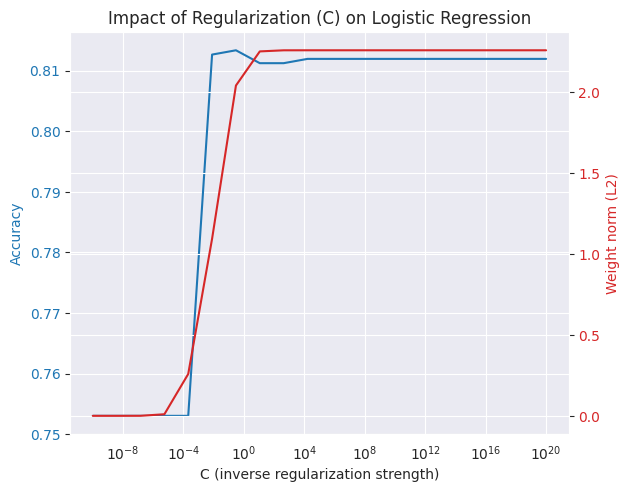

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

# Assume df_train_full, df_test, categorical, numerical, y_test are already defined in user context
# Prepare training data
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat = ohe.fit_transform(df_train_full[categorical].values)

scaler = StandardScaler()
X_train_num = scaler.fit_transform(df_train_full[numerical].values)

X_full_train = np.column_stack([X_train_num, X_train_cat])
y_full_train = df_train_full.churn.values

# Prepare test data
X_test_num = scaler.transform(df_test[numerical].values)
X_test_cat = ohe.transform(df_test[categorical].values)
X_test = np.column_stack([X_test_num, X_test_cat])

# Evaluate performance over different C values
C_values = np.logspace(-10, 20, 20)
accuracies = []
weight_norms = []

for C in C_values:
    model = LogisticRegression(C=C, solver='lbfgs', max_iter=1000)
    model.fit(X_full_train, y_full_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    norm = np.linalg.norm(model.coef_)
    accuracies.append(acc)
    weight_norms.append(norm)

# Plot accuracy and weight norm vs C
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('C (inverse regularization strength)')
ax1.set_ylabel('Accuracy', color=color)
ax1.semilogx(C_values, accuracies, label='Accuracy', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Weight norm (L2)', color=color)
ax2.semilogx(C_values, weight_norms, label='Weight norm', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Impact of Regularization (C) on Logistic Regression")
plt.show()


#### 🔴 **Courbe rouge : norme L2 des poids**

* **Zone à gauche (C ≪ 1)** : les poids sont très petits → **forte régularisation**
* **Zone à droite (C ≫ 1)** : les poids deviennent plus grands → **faible régularisation**

> La norme L2 croît presque linéairement (en log-échelle) avec C

---

#### 🔵 **Courbe bleue : accuracy**

* **Début (C très petit)** :

  * Accuracy ≈ 0.755 → le modèle est **sous-entraîné**
  * Les poids sont trop contraints pour apprendre
* **Montée rapide (C entre 10⁻³ et 10⁻¹)** :

  * Grosse amélioration de la performance
  * Le modèle commence à s’exprimer
* **Plateau (C > 0.1)** :

  * Accuracy ≈ 0.811 et **ne progresse plus**
  * Trop augmenter C ne donne plus rien → **diminishing returns**
  * La norme L2 continue à monter, mais **sans gain de performance**

---

### 🧠 Interprétation clé :

* Le **meilleur compromis régularisation/performance** est autour de :

  $$
  \boxed{C \approx 0.1 \text{ à } 1}
  $$
* Aller au-delà (ex: `C = 100`) **n’apporte rien en accuracy** mais **rend le modèle plus complexe** inutilement.




In [42]:
np.linalg.cond(X_full_train.T @ X_full_train)

np.float64(1.699578584538685e+34)

Condition number super mauvais mais solution stable

b### 🔁 Comparaison des modèles utilisés dans les leçons

#### Modèles de régression (leçons précédentes) :

* `LinearRegression`

  * Tâche : régression (prédire une valeur continue comme un prix)
  * Pas de régularisation
  * Optimise l'erreur quadratique moyenne (MSE)
  * Sensible à l’overfitting si les features sont corrélées ou nombreuses

* `RidgeRegression`

  * Même modèle que `LinearRegression`
  * Ajoute une régularisation L2 : pénalise la norme des poids
  * Permet de stabiliser les solutions si les données sont mal conditionnées ou bruitées
  * Contrôle de la régularisation via `alpha` (plus `alpha` est grand, plus les poids sont contraints)

---

#### Modèles de classification (leçon actuelle) :

* `LogisticRegression`

  * Tâche : classification binaire (ici : prédire si le prix est supérieur ou égal à 152)
  * Sortie = probabilité via une fonction sigmoïde
  * La classe est déterminée avec un seuil (souvent 0.5)
  * Régularisation L2 activée par défaut (paramètre `C`, inverse de la force de régularisation)
  * `C` petit → forte régularisation, `C` grand → modèle plus libre

* `LogisticRegression(penalty=None)`

  * Identique mais sans régularisation
  * Risque d’instabilité si les données sont mal conditionnées (rang déficient, colinéarités…)

---

#### Récapitulatif :

| Modèle                             | Tâche          | Régularisation       | Sortie               | Perte optimisée             |
| ---------------------------------- | -------------- | -------------------- | -------------------- | --------------------------- |
| `LinearRegression`                 | Régression     | Non                  | Valeur réelle        | MSE                         |
| `Ridge`                            | Régression     | Oui (L2)             | Valeur réelle        | MSE + L2                    |
| `LogisticRegression`               | Classification | Oui (L2, par défaut) | Probabilité + classe | Log-loss (entropie croisée) |
| `LogisticRegression` sans pénalité | Classification | Non                  | Probabilité + classe | Log-loss                    |






### 🔄 Pourquoi la sigmoïde est utilisée en `LogisticRegression`

* La régression logistique produit une **combinaison linéaire des features** (comme `LinearRegression`), mais au lieu de sortir directement une valeur, elle applique une **fonction sigmoïde** :

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

* La sigmoïde transforme n’importe quel nombre réel $z \in (-\infty, \infty)$ en une **valeur comprise entre 0 et 1**.

#### Avantages :

* **Interprétation probabiliste** directe : sortie = $P(Y = 1 \mid X)$
* Permet de **classifier** avec un simple seuil (souvent 0.5)
* Évite des prédictions absurdes (< 0 ou > 1), ce qui arrive avec `LinearRegression` si utilisé pour la classification

---

Le graphique ci-dessus montre :

* `LinearRegression` : sortie non bornée, augmente linéairement
* `LogisticRegression` : sortie compressée entre 0 et 1 grâce à la sigmoïde



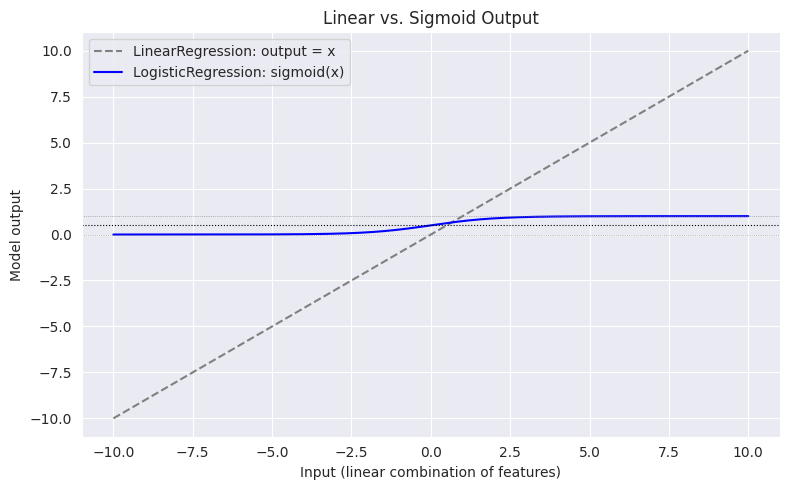

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Linear output (regression) and sigmoid-transformed output (classification)
x = np.linspace(-10, 10, 500)
linear_output = x
sigmoid_output = 1 / (1 + np.exp(-x))

plt.figure(figsize=(8, 5))
plt.plot(x, linear_output, label='LinearRegression: output = x', linestyle='--', color='gray')
plt.plot(x, sigmoid_output, label='LogisticRegression: sigmoid(x)', color='blue')
plt.axhline(0.5, color='black', linestyle=':', linewidth=0.8)
plt.axhline(0, color='gray', linestyle=':', linewidth=0.5)
plt.axhline(1, color='gray', linestyle=':', linewidth=0.5)
plt.xlabel('Input (linear combination of features)')
plt.ylabel('Model output')
plt.title('Linear vs. Sigmoid Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
